## CNN Architecture

Recall that CNN's are defined by a few types of layers:
* Convolutional layers
* Maxpooling layers
* Fully-connected layers

## PyTorch Neural Nets


In [2]:
# import the usual resources
import matplotlib.pyplot as plt
import numpy as np

# import utilities to keep workspaces alive during model training
from workspace_utils import active_session

# watch for any changes in model.py, if it changes, re-load it automatically
%load_ext autoreload
%autoreload 2

In [4]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net

net = Net()
print(net)

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1000, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=1000, out_features=800, bias=True)
  (fc2_drop): Dropout(p=0.1)
  (fc3): Linear(in_features=800, out_features=136, bias=True)
)


In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# the dataset we created in Notebook 1 is copied in the helper file `data_load.py`
from data_load import FacialKeypointsDataset
# the transforms we defined in Notebook 1 are in the helper file `data_load.py`
from data_load import Rescale, RandomCrop, Normalize, ToTensor


## TODO: define the data_transform using transforms.Compose([all tx's, . , .])
# order matters! i.e. rescaling should come before a smaller crop
data_transform = transforms.Compose([Rescale(250),
                                     RandomCrop(224),
                                     Normalize(),
                                     ToTensor()])
# testing that you've defined a transform
assert(data_transform is not None), 'Define a data_transform'

In [6]:
# create the transformed dataset
transformed_dataset = FacialKeypointsDataset(csv_file='./data/training_frames_keypoints.csv',
                                             root_dir='./data/training/',
                                             transform=data_transform)


print('Number of images: ', len(transformed_dataset))

# iterate through the transformed dataset and print some stats about the first few samples
for i in range(4):
    sample = transformed_dataset[i]
    print(i, sample['image'].size(), sample['keypoints'].size())

Number of images:  3462


C:\Users\Lily\Desktop\Udacity\data_load.py:39: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  key_pts = self.key_pts_frame.iloc[idx, 1:].as_matrix()


0 torch.Size([1, 224, 224]) torch.Size([68, 2])
1 torch.Size([1, 224, 224]) torch.Size([68, 2])
2 torch.Size([1, 224, 224]) torch.Size([68, 2])
3 torch.Size([1, 224, 224]) torch.Size([68, 2])


## Batching and loading data



In [10]:
# load training data in batches
batch_size = 32

train_loader = DataLoader(transformed_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)


## Before training

#### Load in the test dataset

In [8]:
# load in the test data, using the dataset class
# AND apply the data_transform you defined above

# create the test dataset
test_dataset = FacialKeypointsDataset(csv_file='./data/test_frames_keypoints.csv',
                                             root_dir='.//data/test/',
                                             transform=data_transform)



In [11]:
# load test data in batches
batch_size = 32

test_loader = DataLoader(test_dataset, 
                          batch_size=batch_size,
                          shuffle=True, 
                          num_workers=4)

## Apply the model on a test sample

In [12]:
# test the model on a batch of test images

def net_sample_output():
    # iterate through the test dataset
    for i, sample in enumerate(test_loader):
        
        # get sample data: images and ground truth keypoints
        images = sample['image']
        key_pts = sample['keypoints']

        # convert images to FloatTensors
        images = images.type(torch.FloatTensor)

        # forward pass to get net output
        output_pts = net(images)
        
        # reshape to batch_size x 68 x 2 pts
        #output_pts = output_pts.view(output_pts.size()[0], 68, -1)
        output_pts = output_pts.view(output_pts.size()[0], 68, -1)

        # break after first image is tested
        if i == 0:
            return images, output_pts, key_pts
            

In [13]:
## TODO: Define the Net in models.py

import torch
import torch.nn as nn
import torch.nn.functional as F

## TODO: Once you've define the network, you can instantiate it
# one example conv layer has been provided for you
from models import Net


# call the above function
# returns: test images, test predicted keypoints, test ground truth keypoints
print(net)
test_images, test_outputs, gt_pts = net_sample_output()

# print out the dimensions of the data to see if they make sense
print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

Net(
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(2, 2), stride=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(1, 1), stride=(1, 1))
  (fc1): Linear(in_features=18432, out_features=1000, bias=True)
  (fc1_drop): Dropout(p=0.4)
  (fc2): Linear(in_features=1000, out_features=800, bias=True)
  (fc2_drop): Dropout(p=0.1)
  (fc3): Linear(in_features=800, out_features=136, bias=True)
)
torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


In [14]:
test_outputs.shape

torch.Size([32, 68, 2])

## Visualize the predicted keypoints


In [15]:
def show_all_keypoints(image, predicted_key_pts, gt_pts=None):
    """Show image with predicted keypoints"""
    # image is grayscale
    plt.imshow(image, cmap='gray')
    plt.scatter(predicted_key_pts[:, 0], predicted_key_pts[:, 1], s=20, marker='.', c='m')
    # plot ground truth points as green pts
    if gt_pts is not None:
        plt.scatter(gt_pts[:, 0], gt_pts[:, 1], s=20, marker='.', c='g')


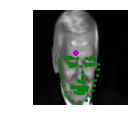

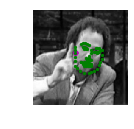

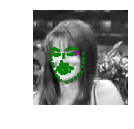

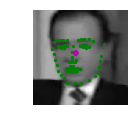

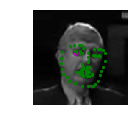

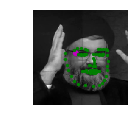

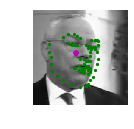

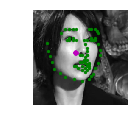

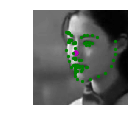

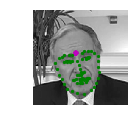

In [16]:
# visualize the output
# by default this shows a batch of 10 images
def visualize_output(test_images, test_outputs, gt_pts=None, batch_size=10):

    for i in range(batch_size):
        plt.figure(figsize=(20,10))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the image data
        image = test_images[i].data   # get the image from it's Variable wrapper
        image = image.numpy()   # convert to numpy array from a Tensor
        image = np.transpose(image, (1, 2, 0))   # transpose to go from torch to numpy image

        # un-transform the predicted key_pts data
        predicted_key_pts = test_outputs[i].data
        predicted_key_pts = predicted_key_pts.numpy()
        # undo normalization of keypoints  
        predicted_key_pts = predicted_key_pts*50.0+100
        
        # plot ground truth points for comparison, if they exist
        ground_truth_pts = None
        if gt_pts is not None:
            ground_truth_pts = gt_pts[i]         
            ground_truth_pts = ground_truth_pts*50.0+100
        
        # call show_all_keypoints
        show_all_keypoints(np.squeeze(image), predicted_key_pts, ground_truth_pts)
            
        plt.axis('off')

    plt.show()
    
# call it
visualize_output(test_images, test_outputs, gt_pts)

## Training

#### Loss function
Training a network to predict keypoints is different than training a network to predict a class; instead of outputting a distribution of classes and using cross entropy loss

In [17]:
use_cuda = torch.cuda.is_available()
# use_cuda = False

FloatTensor = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
LongTensor = torch.cuda.LongTensor if use_cuda else torch.LongTensor
Tensor = FloatTensor

print("USE CUDA=" + str (use_cuda))

#torch.backends.cudnn.benchmark = True

USE CUDA=True


In [18]:
## TODO: Define the loss and optimization
import torch.optim as optim

criterion = nn.SmoothL1Loss()

optimizer = optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.99), eps=1e-08)

## Training and Initial Observation

In [19]:
def train_net(n_epochs):

    # prepare the net for training
    net.train()

    for epoch in range(n_epochs):  # loop over the dataset multiple times
        
        running_loss = 0.0

        # train on batches of data, assumes you already have train_loader
        for batch_i, data in enumerate(train_loader):
            # get the input images and their corresponding labels
            images = data['image']
            key_pts = data['keypoints']

            # flatten pts
            key_pts = key_pts.view(key_pts.size(0), -1)

            # convert variables to floats for regression loss
            key_pts = key_pts.type(torch.FloatTensor)
            images = images.type(torch.FloatTensor)

            # forward pass to get outputs
            output_pts = net(images)

            # calculate the loss between predicted and target keypoints
            loss = criterion(output_pts, key_pts)

            # zero the parameter (weight) gradients
            optimizer.zero_grad()
            
            # backward pass to calculate the weight gradients
            loss.backward()

            # update the weights
            optimizer.step()

            # print loss statistics
            running_loss += loss.item()
            if batch_i % 10 == 9:    # print every 10 batches
                print('Epoch: {}, Batch: {}, Avg. Loss: {}'.format(epoch + 1, batch_i+1, running_loss/10))
                running_loss = 0.0

    print('Finished Training')


In [20]:
n_epochs = 15 # start small, and increase when you've decided on your model structure and hyperparams
train_net(n_epochs)

Epoch: 1, Batch: 10, Avg. Loss: 0.19942964538931846
Epoch: 1, Batch: 20, Avg. Loss: 0.12597991898655891
Epoch: 1, Batch: 30, Avg. Loss: 0.10402950495481492
Epoch: 1, Batch: 40, Avg. Loss: 0.09156361594796181
Epoch: 1, Batch: 50, Avg. Loss: 0.09853403344750404
Epoch: 1, Batch: 60, Avg. Loss: 0.10303995013237
Epoch: 1, Batch: 70, Avg. Loss: 0.08691470921039582
Epoch: 1, Batch: 80, Avg. Loss: 0.09741187393665314
Epoch: 1, Batch: 90, Avg. Loss: 0.09984127879142761
Epoch: 1, Batch: 100, Avg. Loss: 0.08772313483059406
Epoch: 2, Batch: 10, Avg. Loss: 0.09648220464587212
Epoch: 2, Batch: 20, Avg. Loss: 0.11100983992218971
Epoch: 2, Batch: 30, Avg. Loss: 0.1094718337059021
Epoch: 2, Batch: 40, Avg. Loss: 0.10135191306471825
Epoch: 2, Batch: 50, Avg. Loss: 0.09940483272075654
Epoch: 2, Batch: 60, Avg. Loss: 0.09982052370905876
Epoch: 2, Batch: 70, Avg. Loss: 0.09089913368225097
Epoch: 2, Batch: 80, Avg. Loss: 0.08498542383313179
Epoch: 2, Batch: 90, Avg. Loss: 0.09426614828407764
Epoch: 2, Batch

## Test data

In [25]:
# get a sample of test data again
test_images, test_outputs, gt_pts = net_sample_output()

print(test_images.data.size())
print(test_outputs.data.size())
print(gt_pts.size())

torch.Size([32, 1, 224, 224])
torch.Size([32, 68, 2])
torch.Size([32, 68, 2])


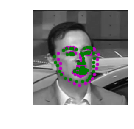

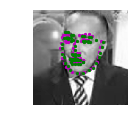

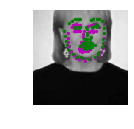

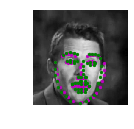

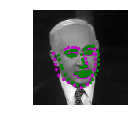

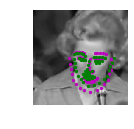

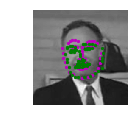

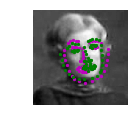

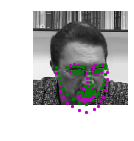

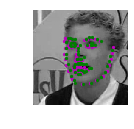

In [26]:
## TODO: visualize your test output
# you can use the same function as before, by un-commenting the line below:

visualize_output(test_images, test_outputs, gt_pts)

In [30]:
## TODO: change the name to something uniqe for each new model
model_dir = './saved_models/'
model_name = 'keypoints_model_1.pt'

# after training, save your model parameters in the dir 'saved_models'
torch.save(net.state_dict(), model_dir+model_name)

## Feature Visualization

[[ 0.06914063  0.19402416  0.06043455 -0.12157942  0.06226995]
 [ 0.06960693 -0.17467375 -0.00763237  0.14908509 -0.19025545]
 [ 0.07470935  0.03470254 -0.05722142 -0.11815868  0.09087221]
 [ 0.07488482 -0.09857623 -0.18930443 -0.00948348  0.05029292]
 [ 0.03480566 -0.00562943 -0.12846456 -0.01502916  0.13216956]]
(5, 5)
[[ 0.01816105  0.21853438  0.129762    0.07857018  0.07720784]
 [-0.16414082  0.04822401  0.05544062 -0.18446656 -0.1298341 ]
 [-0.12166744  0.17218259 -0.16581851 -0.07429098 -0.01294934]
 [-0.11888029  0.01186572  0.09915438  0.03726066 -0.08460787]
 [-0.1538535   0.15344463 -0.1050218   0.10250316 -0.05613856]]
(5, 5)
[[-0.18398038 -0.11311272  0.02940788  0.01161701  0.07013881]
 [ 0.00942567 -0.0363479  -0.18546839 -0.1445186  -0.06400715]
 [ 0.06464115 -0.07316988 -0.095094   -0.14639394 -0.04582227]
 [-0.1366178  -0.19704296 -0.06931228  0.19493544 -0.1853824 ]
 [ 0.07318508  0.18795383  0.03550824 -0.03733334 -0.16026582]]
(5, 5)
[[-0.00351035  0.17002931  0.08

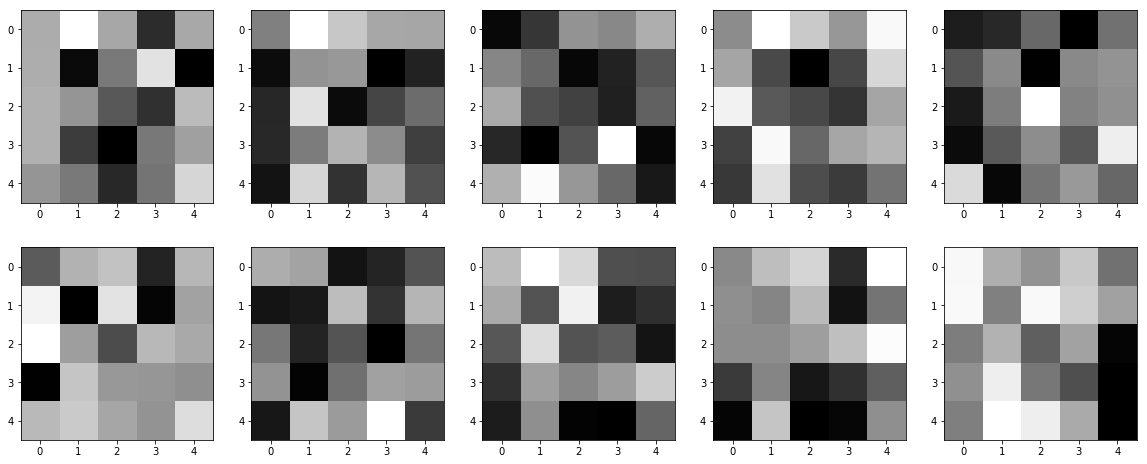

In [34]:
# Get the weights in the first conv layer, "conv1"
# if necessary, change this to reflect the name of your first conv layer
weights1 = net.conv1.weight.data

w = weights1.numpy()

#filter_index = 0


fig=plt.figure(figsize=(20, 8))

for filter_index in range(0, 5*2):
    fig.add_subplot(2, 5, filter_index+1)
    print(w[filter_index][0]);print(w[filter_index][0].shape)
    plt.imshow(w[filter_index][0], cmap='gray')
# display the filter weights
plt.show()

## Feature maps

Each CNN has at least one convolutional layer that is composed of stacked filters (also known as convolutional kernels). As a CNN trains, it learns what weights to include in it's convolutional kernels and when these kernels are applied to some input image, they produce a set of **feature maps**.

All 64 filters from the first convolutional layer applied to an image


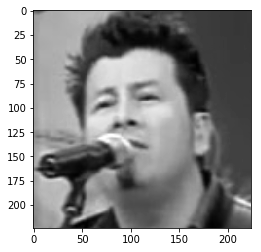

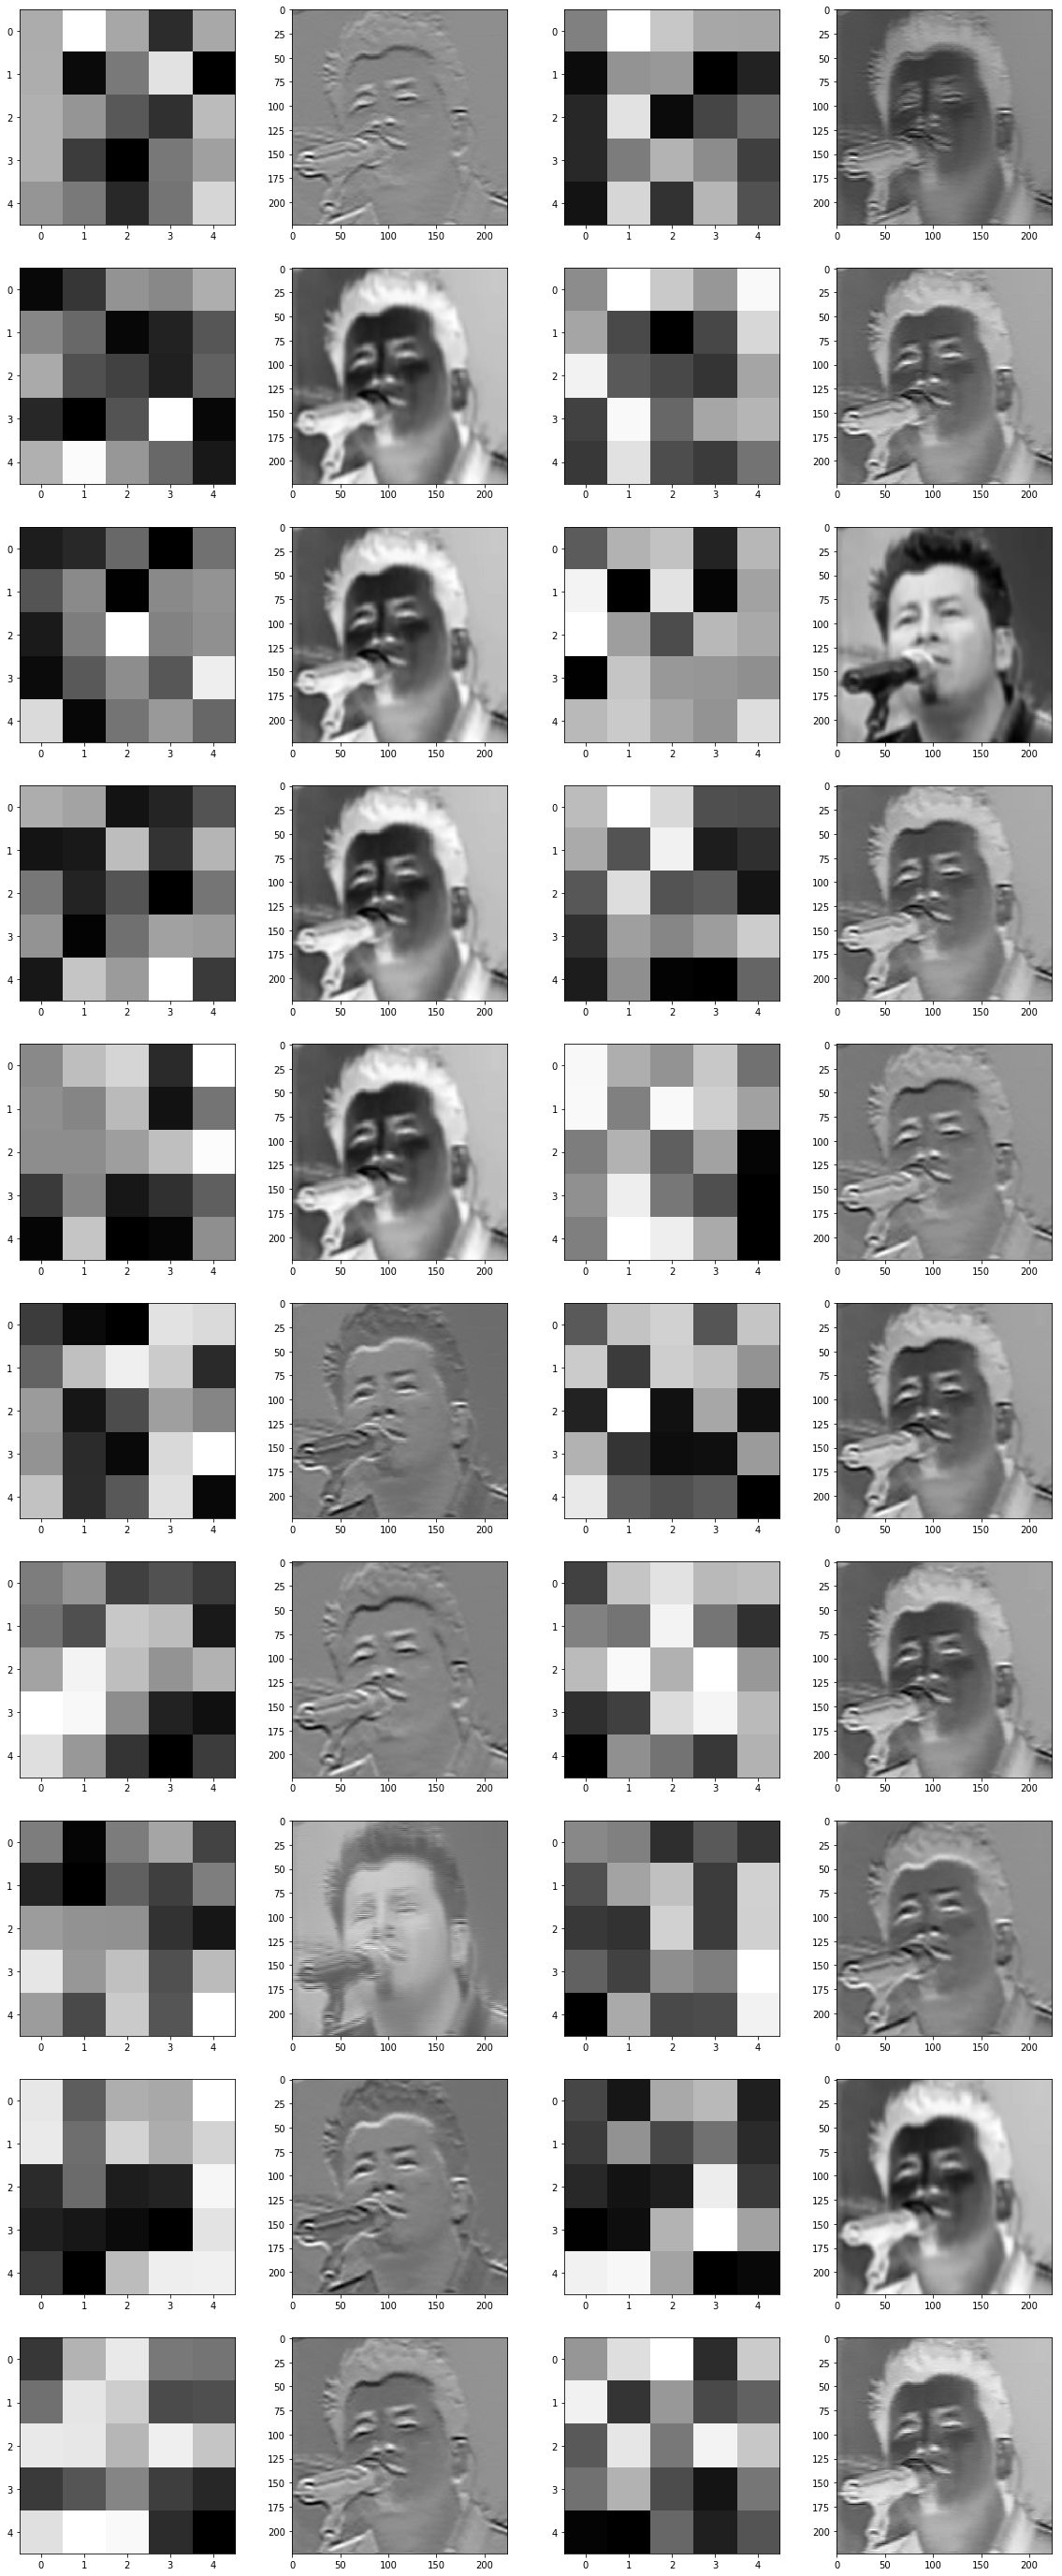

In [49]:
## TODO: Using cv's filter2D function,
## apply a specific set of filter weights (like the one displayed above) to the test image
import cv2

# obtain test dateset
test_dataset = test_loader.dataset

# select an image by index
idx = 670

# un-transform the image data

img = test_dataset[idx]['image']
img = img.numpy()   # convert to numpy array from a Tensor
plt.imshow(img[0], cmap='gray')

weights = net.conv1.weight.data

w = weights.numpy()

# second conv layer
# for 20 filters
fig=plt.figure(figsize=(20, 50))
columns = 4
rows = 10
for i in range(0, columns*rows):
    fig.add_subplot(rows, columns, i+1)
    if ((i%2)==0):
        plt.imshow(w[int(i/2)][0], cmap='gray')
    else:
        c = cv2.filter2D(img, -1, w[int((i-1)/2)][0])
        plt.imshow(c[0], cmap='gray')
print('All 20 filters from the first convolutional layer applied to an image')
plt.show()